# Solving the Incompressible Semi-Geostrophic Problem in 2D

First load in the neccessary packages and paths.

In [1]:
import initialconditions as ic
import matplotlib.pyplot as plt

import main as main
import sys
sys.path.append("/home/s2250115/petsc/arch-linux-c-debug/lib")

import animators as ani

Now set up the initial condition and visualize it.

In [ ]:
# Define the parameters of the system
N = 225 #Number of seeds
box = [-1, -2, 1, 2] #list or tuple defining domain [xmin, ymin, xmax, ymax]
per_tol = 1e-3 #Percent tolerance
periodic_x = True # Set the periodicity of X
periodic_y = False # Set the periodicity of Y
a = 2 # Set the replication parameter
tf = 1 #Final time
Ndt = 100 #Number of timesteps

#Initialize initial condition
Z = ic.create_initial(N, -1, 0, 1, 2, 'lattice') 

#Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot()
ax.scatter(Z[:,0], Z[:,1], color= 'red', s = 8)
ax.set_xlim([-1, 1])
ax.set_ylim([-5, 5])
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

Solve the problem and save the data

In [ ]:
main.SG_solver(box, Z, N, per_tol, tf, Ndt, periodic_x, periodic_y, a) #Solve and save the solution

Animate the solutions

In [ ]:
ani.point_animator('./SG_data.npz', 'C', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' 
ani.point_animator('./SG_data.npz', 'Z', tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' 
#ani.cell_animator('./SG_data.npz', box)

# Code for experimenting with impelementing periodicity

In [6]:
from pysdot.domain_types import ConvexPolyhedraAssembly
from pysdot import OptimalTransport
from pysdot import PowerDiagram
import numpy as np
import pyvista as pv
import weightguess as wg

nb_diracs = 1225

positions = ic.create_initial(nb_diracs, -1, -2, 1, 2, 'lattice') 
masses =  8 * np.ones( nb_diracs ) / nb_diracs

domain = ConvexPolyhedraAssembly()
domain.add_box([-3, -2], [3, 2])
box = [-1, -2, 1, 2]
psi = np.zeros(shape = (nb_diracs,))

# we have to specify that dirac masses because by default, sdot takes ones * measure( domain ) / nb_diracs
# and that's not what we want in this case
w0 = wg.rescale_weights(box, positions, psi, True, False)[0]
ot = OptimalTransport( positions = positions, domain = domain, masses = masses, weights = w0 )

# first arg of add_replication is a translation
for x in [ -2, 2 ]:
    ot.pd.add_replication( [ x, 0 ] )

ot.adjust_weights()

filename = 'pb.vtk'
ot.pd.display_vtk( 'pb.vtk' )

8.000000000000076


/home/s2250115/.local/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


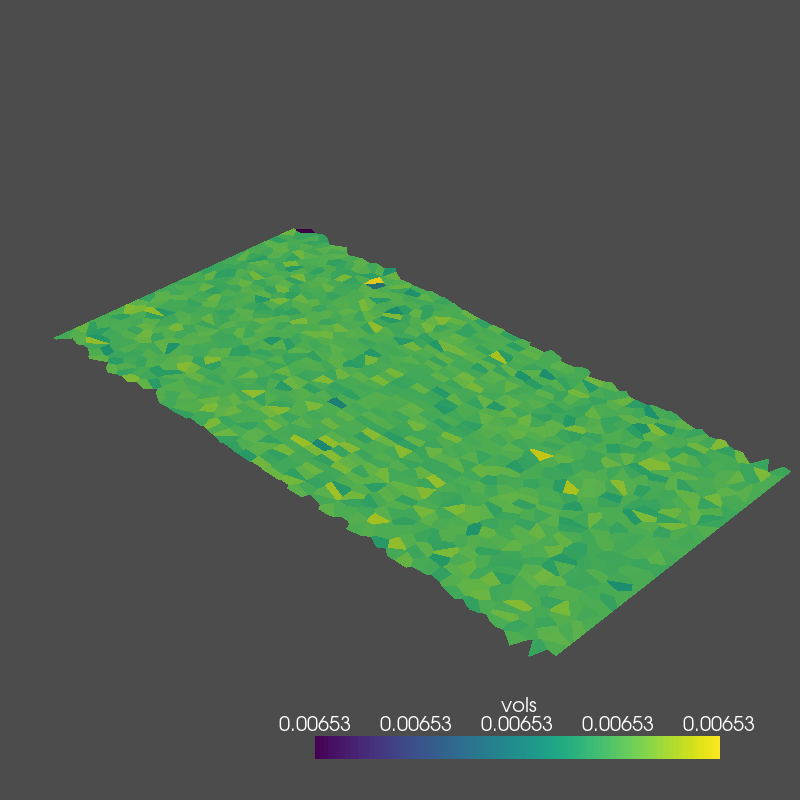

In [7]:
# Mass of cells
vols=ot.pd.integrals()
print(sum(vols))

# Read the data
grid=pv.read(filename)

# create cell data that gives the cell volumes, this allows us to colour by cell volumes
cell_vols = vols[grid.cell_data['num'].astype(int)]
grid.cell_data['vols']=cell_vols

# plot the data with an automatically created plotter, for a static picture use backend='static'
plotter = pv.Plotter(window_size=[800,800], notebook = True, off_screen=False)
plotter.add_mesh(grid)

# Render the frame
plotter.show()